# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Необходимо построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения

Признаки:
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак:
- Price — цена (евро)

## Подготовка данных

### Импорт библиотек:

In [1]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import phik

from phik.report import plot_correlation_matrix
from phik import report
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

Импорт датасета:

In [2]:
df = pd.read_csv('autos.csv')

### Обзор данных:

In [3]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
df.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


Сразу приведем наименования столбцов к стандартному виду:

In [5]:
for i in df.columns:
    rep = re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower()
    df.rename(columns={i: rep}, inplace=True)

Пропуски:

In [6]:
df.isna().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

Проверка на явные дубликаты и их удаление:

In [7]:
print(df.duplicated().sum())
df = df.drop_duplicates()

4


Уникальные значения столбцов:

In [8]:
for i in df.columns:
    try: #оборачиваем в try-except, т.к. есть пропуски
        print('Уникальные значения столбца:',i)
        print(df[i].unique())
        print()
    except: #
        continue

Уникальные значения столбца: date_crawled
['2016-03-24 11:52:17' '2016-03-24 10:58:45' '2016-03-14 12:52:21' ...
 '2016-03-21 09:50:58' '2016-03-14 17:48:27' '2016-03-19 18:57:12']

Уникальные значения столбца: price
[  480 18300  9800 ... 12395 18429 10985]

Уникальные значения столбца: vehicle_type
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']

Уникальные значения столбца: registration_year
[1993 2011 2004 2001 2008 1995 1980 2014 1998 2005 1910 2016 2007 2009
 2002 2018 1997 1990 2017 1981 2003 1994 1991 1984 2006 1999 2012 2010
 2000 1992 2013 1996 1985 1989 2015 1982 1976 1983 1973 1111 1969 1971
 1987 1986 1988 1970 1965 1945 1925 1974 1979 1955 1978 1972 1968 1977
 1961 1960 1966 1975 1963 1964 5000 1954 1958 1967 1959 9999 1956 3200
 1000 1941 8888 1500 2200 4100 1962 1929 1957 1940 3000 2066 1949 2019
 1937 1951 1800 1953 1234 8000 5300 9000 2900 6000 5900 5911 1933 1400
 1950 4000 1948 1952 1200 8500 1932 1255 3700 3800 4800 1942 7000 1935
 1936 6500

В столбце RegistrationYear существуют некорректные значения года регистрации.
В столбце RegistrationMonth отсутсвует месяц регистрации.
В столбце Power присутвует некорректное значение мощности.

Определим признаки, важные для модели.

К значимым признакам отнесем следующие столбцы:

* VehicleType. Тип машины определяет ее функционал. Чем больше возможносей у машины, тем выше цена.
* Gearbox. Наличие автоматической коробки передач повышает стоимость машины из-за сложности конструкции.
* Power. Мощность в лоашдиных силах (далее л.с.) напрямую влияют на цену.
* Kilometer. Имеет обратно пропорциональную зависиммость от цены. Чем больше километров проехала машина, тем меньше ее надежность и соответсвенно цена.
* FuelType. Тип топлива определяет конструкцию двигателя внутреннего сгорания.
* Brand. Концерн/компания, которая создала автомобиль показывает качество и надежность автомобиля.
* NotRepaired. Машины, которые побывали в дорожно-транспортных проишествиях означает, что машина подвергалась изменениям и ее надежность ниже.
* RegistrationYear. Год регистрации определяет сколько уже лет машина на ходу. соответвенно, чем больше возраст, тем меньше цена.
* Model. В купе с типом машины и брендом може влиять на популярность у покупателей.


Кореляция пирсона (линейные взаимосвязи) не показывает линейные зависимости целевого признака от показателей:

<AxesSubplot:>

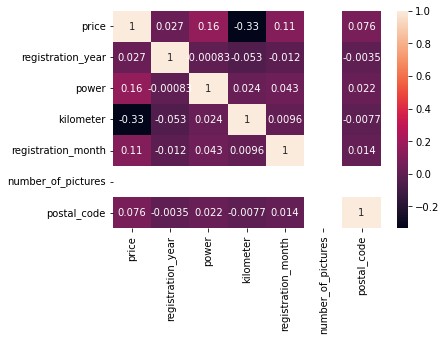

In [9]:
sns.heatmap(df.corr(), annot=True)

Проверим наличие нелинейных взаимосвязей через Phik:

In [10]:
df

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [11]:
phik_overview = df[['vehicle_type', 'registration_year', 'gearbox', 'model', 'fuel_type', 'brand']].phik_matrix()
#phik_overview.round(2)

interval columns not set, guessing: ['registration_year']


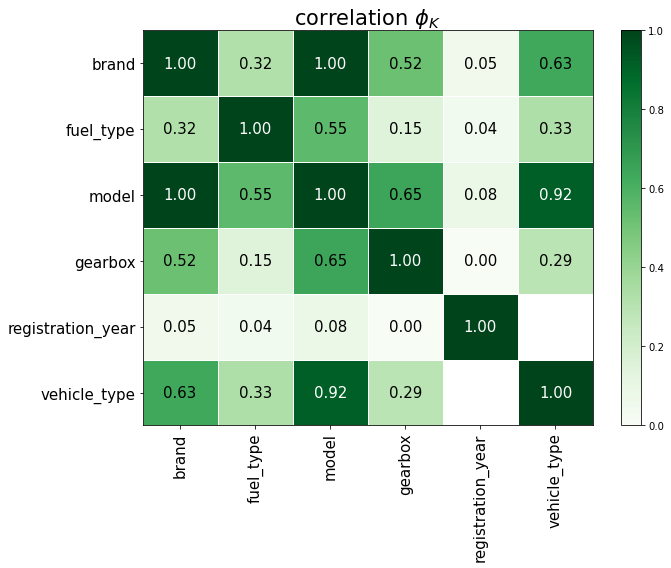

In [12]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(10, 8))
plt.tight_layout()

Наблюдается сильная корреляция между моделю автомобиля и типом его кузова, между маркой и типом кузова и коробкой передач.

### Отбор признаков

Удалим лишние признаки:

In [13]:
df = df.drop(['date_crawled', 'number_of_pictures', 'last_seen', 'postal_code', 'date_created', 'registration_month'], axis=1)

In [14]:
display(df[df.select_dtypes(include="number").columns].apply (['count', 'min', 'max', 'mean']).style.format("{:,.2f}"))

,price,registration_year,power,kilometer
count,"354,365.00","354,365.00","354,365.00","354,365.00"
min,0.00,"1,000.00",0.00,"5,000.00"
max,"20,000.00","9,999.00","20,000.00","150,000.00"
mean,"4,416.68","2,004.23",110.09,"128,211.36"


### Обзор данных и удаление выбросов:

<AxesSubplot:>

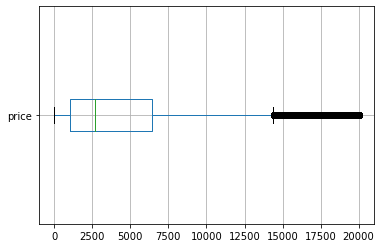

In [15]:
df.boxplot('price', vert = False)

count    354365.000000
mean       4416.679830
std        4514.176349
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64

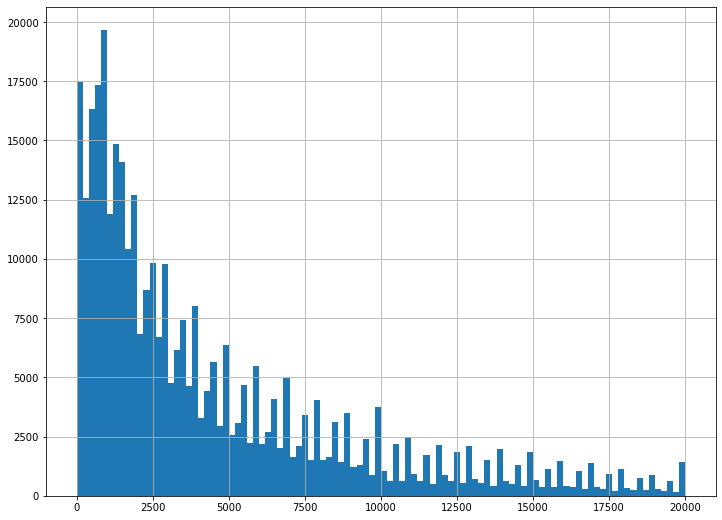

In [16]:
df['price'].hist(bins=100, figsize=(12,9))
df['price'].describe()

In [17]:
df['price'].quantile([.05, 0.95])

0.05      200.0
0.95    14600.0
Name: price, dtype: float64

In [18]:
df = df.query('200 <= price <= 10001')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 293648 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              293648 non-null  int64 
 1   vehicle_type       263749 non-null  object
 2   registration_year  293648 non-null  int64 
 3   gearbox            278766 non-null  object
 4   power              293648 non-null  int64 
 5   model              278422 non-null  object
 6   kilometer          293648 non-null  int64 
 7   fuel_type          267770 non-null  object
 8   brand              293648 non-null  object
 9   repaired           234463 non-null  object
dtypes: int64(4), object(6)
memory usage: 24.6+ MB


count    293648.000000
mean       2003.225750
std          67.074362
min        1000.000000
25%        1999.000000
50%        2002.000000
75%        2006.000000
max        9999.000000
Name: registration_year, dtype: float64

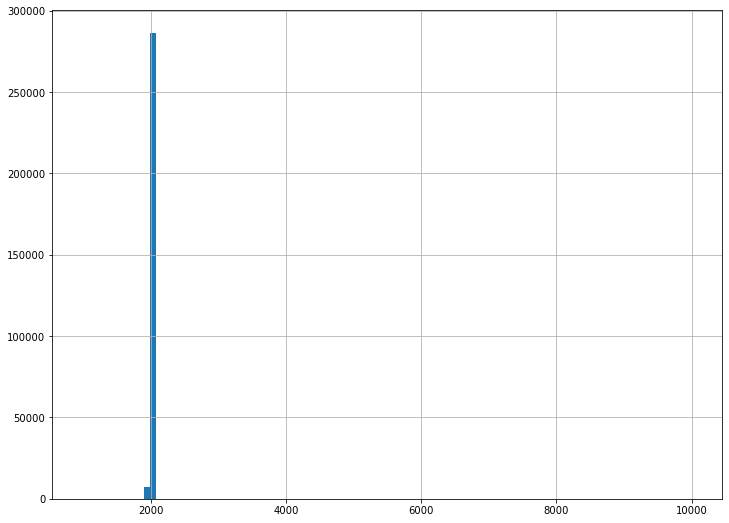

In [19]:
df['registration_year'].hist(bins=100, figsize=(12,9))
df['registration_year'].describe()

Даты регистрации после 2016 года некорректны и машины появились не раньше 1900 года. Отсечем ненужные года:

count    280800.000000
mean       2001.873803
std           6.386862
min        1910.000000
25%        1999.000000
50%        2002.000000
75%        2006.000000
max        2016.000000
Name: registration_year, dtype: float64

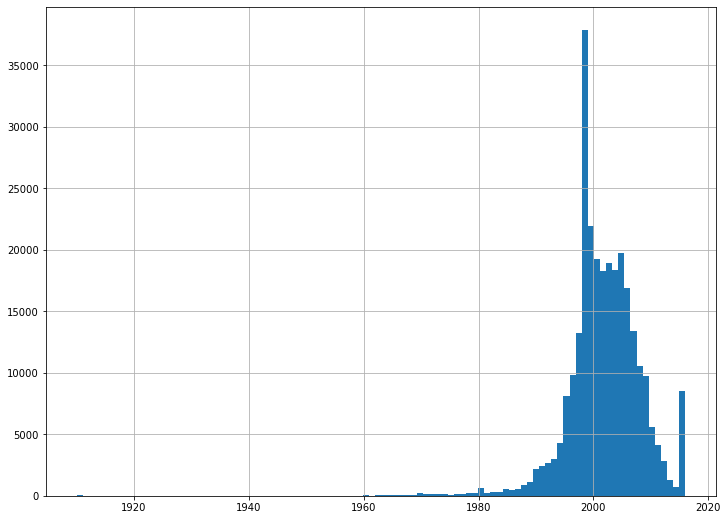

In [20]:
df = df.query('1899 < registration_year < 2017')
df['registration_year'].hist(bins=100, figsize=(12,9))
df['registration_year'].describe()

Количество значений менее 1960 незначительное, отсечем их:

count    280638.000000
mean       2001.907650
std           6.217156
min        1960.000000
25%        1999.000000
50%        2002.000000
75%        2006.000000
max        2016.000000
Name: registration_year, dtype: float64

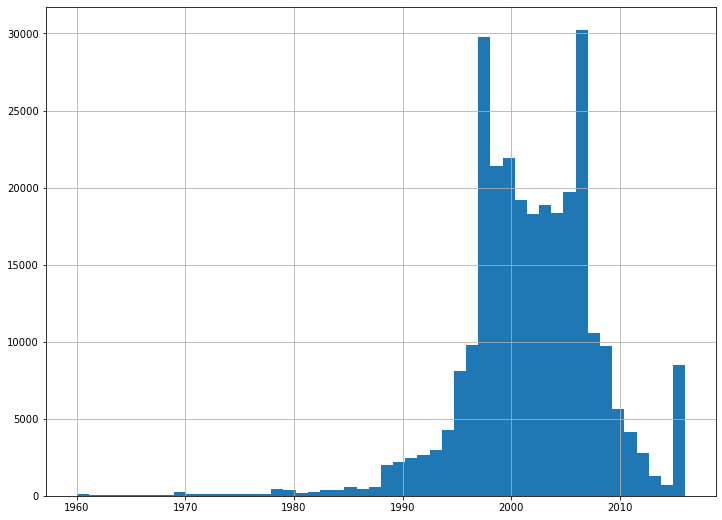

In [21]:
df = df.query('1959 < registration_year')
df['registration_year'].hist(bins=50, figsize=(12,9))
df['registration_year'].describe()

In [22]:
df['power'].describe()

count    280638.000000
mean        104.582640
std         182.924495
min           0.000000
25%          68.000000
50%         101.000000
75%         136.000000
max       20000.000000
Name: power, dtype: float64

Максимальная мощность двигателя автомобиля в истории - 5000 л.с., однако значения >1000 также практически не встречаются. Значения выше считаем выбросами. Значения <10  также аномально малы

In [23]:
df = df.query('10 < power < 1000')

<AxesSubplot:>

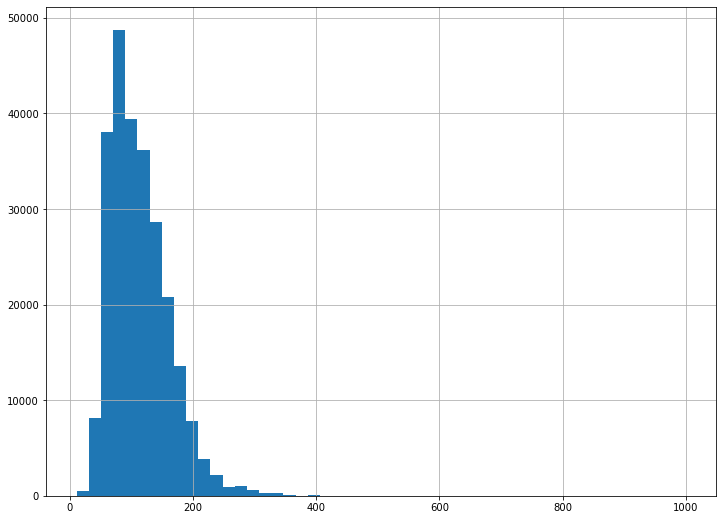

In [24]:
df['power'].hist(bins=50, figsize=(12,9))

### Заполнение пропусков:

In [25]:
df.isna().sum()

price                    0
vehicle_type          9865
registration_year        0
gearbox               4829
power                    0
model                 9619
kilometer                0
fuel_type            14036
brand                    0
repaired             38951
dtype: int64

Значения `gearbox`, `not_repaired`, `model` заполним следующим образом:

In [26]:
df.fillna({'gearbox':'manual',
           'repaired':'yes',
           'model':'unknown'},
            inplace=True)

Заполнение `vehicle_type`. Создадим сводную таблицу по типам кузова для каждого бренда для определения самого популярного значения:

In [27]:
vehicle_type_pivot_table = df.pivot_table(index=['vehicle_type'], 
                                          columns=['brand'],
                                          values=['price'],
                                          aggfunc=['count'])
display(vehicle_type_pivot_table)

count                                                     \
                  price                                                      
brand        alfa_romeo    audi      bmw chevrolet chrysler citroen  dacia   
vehicle_type                                                                 
bus                 NaN     9.0      4.0     105.0    355.0  1069.0   28.0   
convertible       121.0   916.0   2021.0       9.0    188.0    86.0    NaN   
coupe             198.0   716.0   2626.0      46.0     33.0   129.0    NaN   
other               7.0    76.0    190.0      20.0      4.0    91.0    6.0   
sedan             773.0  8199.0  12789.0     172.0    213.0   572.0   94.0   
small             211.0   833.0    330.0     528.0     10.0  1360.0  204.0   
suv                 NaN    19.0    300.0     216.0     13.0    12.0  127.0   
wagon             403.0  7565.0   5639.0      82.0    200.0   505.0  222.0   

                                      ...                          \
                                      ...                           
brand        daewoo daihatsu    fiat  ...    seat   skoda   smart   
vehicle_type                          ...                           
bus            24.0     31.0   681.0  ...   516.0   197.0     NaN   
convertible     1.0     15.0   348.0  ...     NaN     3.0  1021.0   
coupe           5.0      NaN   140.0  ...    66.0     5.0   288.0   
other           3.0      7.0   134.0  ...    43.0    17.0     4.0   
sedan          88.0     37.0   760.0  ...  1375.0   695.0    26.0   
small         214.0    422.0  4457.0  ...  2712.0   981.0  2945.0   
suv             1.0     41.0    18.0  ...     3.0    18.0     NaN   
wagon          39.0     14.0   358.0  ...   269.0  1967.0     9.0   

                                                                              
                                                                              
brand        sonstige_autos subaru suzuki  toyota trabant volkswagen   volvo  
vehicle_type                                                                  
bus                   133.0   14.0   25.0   369.0     NaN     6609.0     NaN  
convertible           177.0    1.0   26.0    56.0    27.0     2177.0    34.0  
coupe                  87.0    3.0    4.0   184.0     2.0      882.0    55.0  
other                  66.0    4.0    9.0    12.0     2.0      570.0     3.0  
sedan                 258.0  124.0  133.0   746.0   129.0    15577.0   522.0  
small                  74.0   98.0  820.0  1405.0    45.0    15338.0     6.0  
suv                   208.0   48.0  593.0   304.0     NaN      393.0    99.0  
wagon                  87.0  251.0   77.0   455.0    50.0    10153.0  1664.0  

[8 rows x 40 columns]

Избавимся от мультииндекса:

In [28]:
vehicle_type_pivot_table = vehicle_type_pivot_table['count']['price']
df.fillna({'vehicle_type':0},inplace=True)

Функция для заполнения пропусков^:

In [29]:
def fillna_by_brand(row, row_number, vehicle_type_pivot_table):
    brand = row[8]
    fill_value = row[row_number]
    if row[row_number] == 0:
        fill_value = vehicle_type_pivot_table[brand].idxmax()
    return fill_value

In [30]:
df['vehicle_type'] = df.apply(
                        fillna_by_brand, 
                        args=[1, vehicle_type_pivot_table],
                        axis=1)
display(df['vehicle_type'].isna().sum())
df['vehicle_type'].value_counts()

0

sedan          75948
small          69873
wagon          49984
bus            22039
convertible    14104
coupe          10909
suv             6269
other           2179
Name: vehicle_type, dtype: int64

Проверка: в 1-й строке тип кузова volkswagen заполнился самым популярным значениям для этой модели бренда:

In [31]:
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,yes
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no


Заполнение `fuel_type`. Создадим сводную таблицу по типам кузова для каждого бренда для определения самого популярного значения:

In [32]:
fuel_type_pivot_table = df.pivot_table(index=['fuel_type'], 
                                          columns=['brand'],
                                          values=['price'],
                                          aggfunc=['count'])
display(fuel_type_pivot_table)

count                                                      \
               price                                                       
brand     alfa_romeo     audi      bmw chevrolet chrysler citroen  dacia   
fuel_type                                                                  
cng              NaN      NaN      5.0       4.0      NaN     5.0    2.0   
electric         NaN      2.0      3.0       NaN      NaN     NaN    NaN   
gasoline       503.0   7476.0   6649.0     115.0    283.0  1250.0  126.0   
hybrid           NaN      NaN      NaN       NaN      NaN     NaN    NaN   
lpg             27.0    382.0    640.0     150.0     76.0    61.0   44.0   
other            NaN      1.0      3.0       NaN      NaN     NaN    NaN   
petrol        1158.0  10127.0  15984.0     895.0    630.0  2453.0  491.0   

                                   ...                                         \
                                   ...                                          
brand     daewoo daihatsu    fiat  ...    seat   skoda   smart sonstige_autos   
fuel_type                          ...                                          
cng          NaN      NaN    62.0  ...     NaN     6.0     2.0            6.0   
electric     NaN      1.0     2.0  ...     NaN     NaN     2.0            3.0   
gasoline     1.0      4.0  1165.0  ...  1309.0  1299.0   757.0          199.0   
hybrid       NaN      NaN     3.0  ...     1.0     NaN     1.0            1.0   
lpg         21.0      4.0    59.0  ...    58.0    48.0     3.0           76.0   
other        NaN      NaN     1.0  ...     NaN     NaN     NaN            6.0   
petrol     353.0    541.0  5506.0  ...  3558.0  2477.0  3492.0          760.0   

                                                             
                                                             
brand     subaru  suzuki  toyota trabant volkswagen   volvo  
fuel_type                                                    
cng          2.0     NaN     NaN     NaN      153.0    20.0  
electric     NaN     NaN     NaN     NaN        2.0     NaN  
gasoline    19.0   174.0   776.0     1.0    17759.0   692.0  
hybrid       NaN     NaN    40.0     NaN        3.0     NaN  
lpg         27.0    15.0    15.0     NaN      450.0   102.0  
other        NaN     1.0     NaN    23.0       14.0     2.0  
petrol     478.0  1469.0  2676.0   199.0    32941.0  1505.0  

[7 rows x 40 columns]

In [33]:
fuel_type_pivot_table = fuel_type_pivot_table['count']['price']
df.fillna({'fuel_type':0},inplace=True)

In [34]:
df['fuel_type'] = df.apply(
                        fillna_by_brand, 
                        args=[8, fuel_type_pivot_table],
                        axis=1)

In [35]:
df.isna().sum()

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
dtype: int64

### Замена типов данных:

In [36]:
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
2,9800,suv,2004,auto,163,grand,125000,jeep,jeep,yes
3,1500,small,2001,manual,75,golf,150000,volkswagen,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,skoda,skoda,no
5,650,sedan,1995,manual,102,3er,150000,bmw,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,peugeot,peugeot,no


In [37]:
df['vehicle_type'] = df['vehicle_type'].astype('category')
df['registration_year'] = df['registration_year'].astype('uint32')
df['gearbox'] = df['gearbox'].astype('category')
df['power'] = df['power'].astype('float32')
df['model'] = df['model'].astype('category')
df['fuel_type'] = df['fuel_type'].astype('category')
df['brand'] = df['brand'].astype('category')
df['repaired'] = df['repaired'].astype('bool')

In [38]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 251305 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   price              251305 non-null  int64   
 1   vehicle_type       251305 non-null  category
 2   registration_year  251305 non-null  uint32  
 3   gearbox            251305 non-null  category
 4   power              251305 non-null  float32 
 5   model              251305 non-null  category
 6   kilometer          251305 non-null  int64   
 7   fuel_type          251305 non-null  category
 8   brand              251305 non-null  category
 9   repaired           251305 non-null  bool    
dtypes: bool(1), category(5), float32(1), int64(2), uint32(1)
memory usage: 9.4 MB


In [39]:
display(df[df.select_dtypes(include="number").columns].apply (['count', 'min', 'max', 'mean']).style.format("{:,.2f}"))

,price,registration_year,power,kilometer
count,"251,305.00","251,305.00","251,305.00","251,305.00"
min,200.00,"1,960.00",11.00,"5,000.00"
max,"10,001.00","2,016.00",999.00,"150,000.00"
mean,"3,391.47","2,002.02",112.98,"132,815.60"


Анализ датасета:

**Вывод**
1. Выполнен обзор датасета
2. Исключены дубликаты, аномальные значения, нерелевантные для машинного обучения столбцы
3. Заполнены пропуски в датасете
4. Объем расходования оперативной памяти сокращен с 43.3 Мб до 9.4 Мб.
5. Мультиколлинеарность между признаками не выявлена

## Обучение моделей

В качестве моделей для предсказания оценки автомобилей выберем:
* LinearRegression
* RandoForestRegressor
* LightGBM
* CatBoost

Подготовка признаков:
- Библиотеки градиентного бустинга LightGBM и CatBoost работают с категориальными признаками напрямую, для них не требуется кодировать их в численные. 
-  LinearRegression необходимо работать только с численными значениями, для нее используем dummy-признаки.
-  Для модели RandomForest используем поярдковое кодирование OrdinalEncoder.

Предварительно разделим датасет на выборки во избежание утечки данных с трейн на тест:

In [40]:
target = df['price']
original_features = df.drop('price', axis=1)

In [41]:
original_features_train, original_features_test, target_train, target_test = train_test_split(
    original_features, target, test_size=0.25, random_state=282)

Подготовим дамми-признаки для работы модели LinearRegression:

In [42]:
ohe_features_train = pd.get_dummies(original_features_train, drop_first=True)
ohe_features_test = pd.get_dummies(original_features_test, drop_first=True)

Произведем кодирование признаков для модели RandomForest:

In [43]:
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
2,9800,suv,2004,auto,163.0,grand,125000,jeep,jeep,True
3,1500,small,2001,manual,75.0,golf,150000,volkswagen,volkswagen,True
4,3600,small,2008,manual,69.0,fabia,90000,skoda,skoda,True
5,650,sedan,1995,manual,102.0,3er,150000,bmw,bmw,True
6,2200,convertible,2004,manual,109.0,2_reihe,150000,peugeot,peugeot,True


In [44]:
oe_features_train = original_features_train.copy()
oe_features_test = original_features_test.copy()

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=1000)
encoder.fit(oe_features_train[['vehicle_type','gearbox','model','fuel_type', 'brand']])

oe_features_train[['vehicle_type','gearbox','model','fuel_type', 'brand']] = encoder.transform(
    oe_features_train[['vehicle_type','gearbox','model','fuel_type', 'brand']])

oe_features_test[['vehicle_type','gearbox','model','fuel_type', 'brand']] = encoder.transform(
    oe_features_test[['vehicle_type','gearbox','model','fuel_type', 'brand']])

### Линейная регрессия

Масштабирование в данном случае не требуется,т.к. не влияет на начение RMSE.

In [45]:
%%time

linear_model = LinearRegression()
print('Training for RMSE:')
print()
linear_model_info = (cross_validate(linear_model, 
                             ohe_features_train, 
                             target_train, 
                             cv=5, 
                             scoring='neg_mean_squared_error'))

linear_model_rmse_train = (linear_model_info['test_score'].mean() * -1) ** 0.5
linear_model_fittime_train = linear_model_info['fit_time'].mean()
linear_model_predicttime_train = linear_model_info['score_time'].mean()

print('Mean RMSE from CV of LinearRegression =', linear_model_rmse_train)
print('Mean fittime from CV of LinearRegression =', linear_model_fittime_train)
print('Mean predicttime from CV of LinearRegression =', linear_model_predicttime_train)

Training for RMSE:

Mean RMSE from CV of LinearRegression = 1763.1315815514622
Mean fittime from CV of LinearRegression = 7.277282810211181
Mean predicttime from CV of LinearRegression = 0.21535024642944336
CPU times: total: 53.7 s
Wall time: 37.6 s


На OHE признаках:

* Mean RMSE from CV of LinearRegression = 1763.1315815514647
* Mean fittime from CV of LinearRegression = 22.744531631469727
* Mean predicttime from CV of LinearRegression = 0.9314366340637207
* CPU times: user 1min 6s, sys: 51.1 s, total: 1min 58s
* Wall time: 1min 58s

### RandomForestRegressor

In [48]:
%%time
tree_model = RandomForestRegressor(random_state=282)

parameters = {'criterion': ['squared_error'], 
              'max_depth': range(10, 21, 2),
              'n_estimators': range(15, 45, 4)
              }
clf = GridSearchCV(tree_model, 
                   parameters, 
                   scoring='neg_mean_squared_error', 
                   cv=5, 
                   verbose=2)
clf.fit(oe_features_train, target_train)

print(sorted(clf.cv_results_.keys()))

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
for mean, params in zip(means, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_rf = (max(means)*-1) ** 0.5

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END criterion=squared_error, max_depth=10, n_estimators=15; total time=   5.2s
[CV] END criterion=squared_error, max_depth=10, n_estimators=15; total time=   4.7s
[CV] END criterion=squared_error, max_depth=10, n_estimators=15; total time=   4.0s
[CV] END criterion=squared_error, max_depth=10, n_estimators=15; total time=   3.5s
[CV] END criterion=squared_error, max_depth=10, n_estimators=15; total time=   4.3s
[CV] END criterion=squared_error, max_depth=10, n_estimators=19; total time=   4.1s
[CV] END criterion=squared_error, max_depth=10, n_estimators=19; total time=   4.3s
[CV] END criterion=squared_error, max_depth=10, n_estimators=19; total time=   6.3s
[CV] END criterion=squared_error, max_depth=10, n_estimators=19; total time=   4.3s
[CV] END criterion=squared_error, max_depth=10, n_estimators=19; total time=   4.5s
[CV] END criterion=squared_error, max_depth=10, n_estimators=23; total time=   6.5s
[CV] END crite

In [49]:
cv_RMSE_rf

1145.54069549838

Лучший результат RMSE 1145 на OE признаках при гиперпараметрах {'criterion': 'mse', 'max_depth': 18, 'n_estimators': 44}.

### LightGBM

In [50]:
%%time

lgbm_model = LGBMRegressor(random_state=282) 
parameters = {'num_leaves':[31, 100, 200],
              'learning_rate':[0.1, 0.3, 0.5] }

print('# Tuning hyper-parameters for root_mean_squared_error')
print()
clf = GridSearchCV(lgbm_model, 
                   parameters, 
                   scoring='neg_mean_squared_error', 
                   cv=3,
                   verbose=2)
clf.fit(original_features_train, target_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
for mean, params in zip(means, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_LGBMR = (max(means)*-1) ** 0.5

# Tuning hyper-parameters for root_mean_squared_error

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END ...................learning_rate=0.1, num_leaves=31; total time=   1.2s
[CV] END ...................learning_rate=0.1, num_leaves=31; total time=   1.0s
[CV] END ...................learning_rate=0.1, num_leaves=31; total time=   1.0s
[CV] END ..................learning_rate=0.1, num_leaves=100; total time=   1.4s
[CV] END ..................learning_rate=0.1, num_leaves=100; total time=   1.7s
[CV] END ..................learning_rate=0.1, num_leaves=100; total time=   2.0s
[CV] END ..................learning_rate=0.1, num_leaves=200; total time=   2.4s
[CV] END ..................learning_rate=0.1, num_leaves=200; total time=   3.7s
[CV] END ..................learning_rate=0.1, num_leaves=200; total time=   2.5s
[CV] END ...................learning_rate=0.3, num_leaves=31; total time=   1.4s
[CV] END ...................learning_rate=0.3, num_leaves=31; total time=  

In [51]:
cv_RMSE_LGBMR = (max(means)*-1) ** 0.5

Лучший результат: 1110.761059 for {'learning_rate': 0.1, 'num_leaves': 200}

### CatBoost

In [52]:
%%time

cat_model = CatBoostRegressor(random_state=282, 
                              verbose=2,
                              cat_features=['vehicle_type', 'registration_year', 'gearbox', 'fuel_type','brand','model']) 

parameters = {'iterations':[100, 200, 300],
              'learning_rate':[0.1, 0.3, 0.5] }

print('# Tuning hyper-parameters for root_mean_squared_error')
print()
clf = GridSearchCV(cat_model, 
                   parameters, 
                   scoring='neg_mean_squared_error', 
                   cv=3,
                   verbose=2)
clf.fit(original_features_train, target_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']

for mean, params in zip(means, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_cat = (max(means)*-1) ** 0.5

# Tuning hyper-parameters for root_mean_squared_error

Fitting 3 folds for each of 9 candidates, totalling 27 fits
0:	learn: 2483.0063369	total: 231ms	remaining: 22.8s
2:	learn: 2228.1062301	total: 377ms	remaining: 12.2s
4:	learn: 2036.5096072	total: 545ms	remaining: 10.4s
6:	learn: 1892.3959984	total: 719ms	remaining: 9.55s
8:	learn: 1767.7702464	total: 883ms	remaining: 8.93s
10:	learn: 1676.4497270	total: 1.04s	remaining: 8.4s
12:	learn: 1609.5752080	total: 1.19s	remaining: 7.98s
14:	learn: 1552.6953307	total: 1.35s	remaining: 7.64s
16:	learn: 1507.2472526	total: 1.5s	remaining: 7.34s
18:	learn: 1468.1871166	total: 1.73s	remaining: 7.38s
20:	learn: 1436.6092403	total: 1.96s	remaining: 7.36s
22:	learn: 1404.8278894	total: 2.14s	remaining: 7.16s
24:	learn: 1382.9005426	total: 2.31s	remaining: 6.92s
26:	learn: 1366.3305586	total: 2.47s	remaining: 6.68s
28:	learn: 1353.7788381	total: 2.63s	remaining: 6.45s
30:	learn: 1342.6939872	total: 2.79s	remaining: 6.22s
32:	learn: 1334.8469466	tota

In [53]:
cv_RMSE_cat

1153.8673514302504

Лучший результат RMSE 1153.867351 for {'iterations': 300, 'learning_rate': 0.3}

**Вывод:** подготовлены 4 модели и подобраны лучшие параметры для расчтета метрики MSE. В следующем раздлеле протестируем модели на отобранных параметрах и определим время обучения и предсказания.

## Анализ моделей

### Линейная регрессия

In [54]:
linear_model = LinearRegression()
print('Training for RMSE:')
print()
linear_model_info = (cross_validate(linear_model, 
                             ohe_features_train, 
                             target_train, 
                             cv=5, 
                             scoring='neg_mean_squared_error'))

linear_model_rmse_train = (linear_model_info['test_score'].mean() * -1) ** 0.5
linear_model_fittime_train = linear_model_info['fit_time'].mean()
linear_model_predicttime_train = linear_model_info['score_time'].mean()

print('Mean RMSE from CV of LinearRegression =', linear_model_rmse_train)
print('Mean fittime from CV of LinearRegression =', linear_model_fittime_train)
print('Mean predicttime from CV of LinearRegression =', linear_model_predicttime_train)

Training for RMSE:

Mean RMSE from CV of LinearRegression = 1763.1315815514622
Mean fittime from CV of LinearRegression = 6.918235349655151
Mean predicttime from CV of LinearRegression = 0.2272655487060547


### RandomForestRegressor

In [56]:
model_tree = RandomForestRegressor(criterion='squared_error', 
                                   max_depth=18,
                                   n_estimators=44,
                                   random_state=282) 
print('Training for RMSE:')
print()
rf_model_info = (cross_validate(model_tree, 
                             oe_features_train, 
                             target_train, 
                             cv=5, 
                             scoring='neg_mean_squared_error'))

rf_model_rmse_train = (rf_model_info['test_score'].mean() * -1) ** 0.5
rf_model_fittime_train = rf_model_info['fit_time'].mean()
rf_model_predicttime_train = rf_model_info['score_time'].mean()

print('Mean RMSE from CV of RandomForestRegression =', rf_model_rmse_train)
print('Mean fittime from CV of RandomForestRegressio =', rf_model_fittime_train)
print('Mean predicttime from CV of RandomForestRegressio =', rf_model_predicttime_train)

Training for RMSE:

Mean RMSE from CV of RandomForestRegression = 1145.3040945927778
Mean fittime from CV of RandomForestRegressio = 16.09599609375
Mean predicttime from CV of RandomForestRegressio = 0.41111016273498535


### LightGBM

In [57]:
model_lgbmr = LGBMRegressor(learning_rate=0.1, 
                            num_leaves=200, 
                            random_state=282)

lgbmr_model_info = (cross_validate(model_lgbmr, 
                             original_features_train, 
                             target_train, 
                             cv=5, 
                             scoring='neg_mean_squared_error'))

lgbmr_model_rmse_train = (lgbmr_model_info['test_score'].mean() * -1) ** 0.5
lgbmr_model_fittime_train = lgbmr_model_info['fit_time'].mean()
lgbmr_model_predicttime_train = lgbmr_model_info['score_time'].mean()

print('Mean RMSE from CV of LGBMRegression =', lgbmr_model_rmse_train)
print('Mean fittime from CV of LGBMRegressio =', lgbmr_model_fittime_train)
print('Mean predicttime from CV of LGBMRegressio =', lgbmr_model_predicttime_train)

Mean RMSE from CV of LGBMRegression = 1110.7610585129512
Mean fittime from CV of LGBMRegressio = 2.2826006412506104
Mean predicttime from CV of LGBMRegressio = 0.27852697372436525


### CatBoost

In [58]:
model_cat = CatBoostRegressor(learning_rate=0.3, 
                              iterations=300,
                              random_state=282,
                              cat_features=['vehicle_type', 'registration_year', 'gearbox', 'fuel_type','brand','model'])

cat_model_info = (cross_validate(model_cat, 
                             original_features_train, 
                             target_train, 
                             cv=5, 
                             scoring='neg_mean_squared_error'))

cat_model_rmse_train = (cat_model_info['test_score'].mean() * -1) ** 0.5
cat_model_fittime_train = cat_model_info['fit_time'].mean()
cat_model_predicttime_train = cat_model_info['score_time'].mean()

print('Mean RMSE from CV of CatBoostRegressor =', cat_model_rmse_train)
print('Mean fittime from CV of CatBoostRegressor =', cat_model_fittime_train)
print('Mean predicttime from CV of CatBoostRegressor =', cat_model_predicttime_train)

0:	learn: 2182.9474974	total: 183ms	remaining: 54.8s
1:	learn: 1884.1158447	total: 328ms	remaining: 48.8s
2:	learn: 1684.8922867	total: 489ms	remaining: 48.4s
3:	learn: 1563.7406271	total: 656ms	remaining: 48.6s
4:	learn: 1481.1396760	total: 812ms	remaining: 47.9s
5:	learn: 1423.9219883	total: 977ms	remaining: 47.9s
6:	learn: 1383.0019246	total: 1.22s	remaining: 50.9s
7:	learn: 1358.3427186	total: 1.32s	remaining: 48.2s
8:	learn: 1341.1416021	total: 1.48s	remaining: 47.7s
9:	learn: 1325.2914957	total: 1.61s	remaining: 46.7s
10:	learn: 1315.8926424	total: 1.73s	remaining: 45.5s
11:	learn: 1309.8039051	total: 1.86s	remaining: 44.6s
12:	learn: 1301.9259159	total: 2.05s	remaining: 45.3s
13:	learn: 1293.5563558	total: 2.2s	remaining: 44.9s
14:	learn: 1288.0896123	total: 2.37s	remaining: 45s
15:	learn: 1283.0476353	total: 2.51s	remaining: 44.5s
16:	learn: 1276.8848168	total: 2.68s	remaining: 44.6s
17:	learn: 1271.8153653	total: 2.8s	remaining: 43.9s
18:	learn: 1267.0859467	total: 2.92s	remai

Mean RMSE from CV of CatBoostRegressor = 1148.8662881107728
Mean fittime from CV of CatBoostRegressor = 36.09305157661438
Mean predicttime from CV of CatBoostRegressor = 0.16347842216491698

### Сравнительная таблица

In [63]:
index = ['LinearRegression',
         'RandomForestRegressor',
         'LGBMRegressor',
         'CatBoostRegressor']

data = {'RMSE на CV, евро':[linear_model_rmse_train,
                            rf_model_rmse_train,
                            lgbmr_model_rmse_train,
                            cat_model_rmse_train],
        
        'time fitting':    [linear_model_fittime_train,
                            rf_model_fittime_train,
                            lgbmr_model_fittime_train,
                            cat_model_fittime_train],
                            
        'time predicting':  [linear_model_predicttime_train,
                            rf_model_predicttime_train,
                            lgbmr_model_predicttime_train,
                            cat_model_predicttime_train]}
pivot = pd.DataFrame(data=data, index=index)
pivot.sort_values(by='RMSE на CV, евро')
pivot.sort_values(by='time predicting')


,"RMSE на CV, евро",time fitting,time predicting
CatBoostRegressor,1148.866288,54.917460,0.155862
LinearRegression,1763.131582,6.918235,0.227266
LGBMRegressor,1110.761059,2.282601,0.278527
RandomForestRegressor,1145.304095,16.095996,0.411110


**Вывод по разделу:** Модель Линейной регрессии имеет низккую метрику RMSE. Остальные модели имеют схожие метрики в районе 1145 евро. `CatBoostRegressor` обучается в среднем в 3 раза медленнее, чем `RandomForestRegressor`, однако имеет самое короткое время обучения. `LGBMRegressor` проигрывает им как по времени обучения, так и времени предсказания, при этом имея совсем незначительно лучшую метрику RMSE. Для предоставления клиенту отбираем модель `LGBMRegressor`.

### Итоговый тест

In [68]:
#model_cat = CatBoostRegressor(learning_rate=0.3, 
#                              iterations=300,
#                              random_state=282,
#                              cat_features=['vehicle_type', 'registration_year', 'gearbox', 'fuel_type','brand','model'])
#
%time model_lgbmr.fit(original_features_train, target_train)
%time predict = model_lgbmr.predict(original_features_test)
final_RMSE = mean_squared_error(target_test, predict) ** 0.5

CPU times: total: 7.19 s
Wall time: 1.98 s
CPU times: total: 1.38 s
Wall time: 367 ms


In [70]:
final_RMSE

1109.730458615681

**Вывод:**
1.  Выполнна предобработка и обзор данных
2. Произведен подбор гиперпараметров четырех моделей, результатаы собраны в сводную таблицу. Модель `LGBMRegressor` отобрана для демонстрации заказчику.
4. По итогам финального тестирования модель `LGBMRegressor` показала результат RMSE = 1109 евро, при времени обучения 7.9с и времени предсказания 0.367с